# Sklearn regression pipeline (Phase 2)

In this phase, we perform a grid search for predictor transformations, feature selection and regression type.

In [3]:
%config Completer.use_jedi=False

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [81]:
from pathlib import Path
import pickle 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data import train, validation
from data import X, y, numerical, categorical
import utils

# Create directory to save models
SAVE_DIR = Path('models/')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Specify save file here
SAVE_FILE = SAVE_DIR / 'regression_phase_2.p'

In [2]:
train.head()

,attribute2,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,meanAge,gender,meanEducation,maritalStatus,plus,...,brandID_33,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,attribute1_2,attribute1_3,attribute1_4
1404,4.850075,3.082306,4.281904,3.791205,6.480146,7.813408,1.380382,11.580054,2.201123,1.650476,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2184,2.910045,0.094506,1.709888,1.637009,0.059201,7.600842,0.000000,10.896544,1.410243,1.856786,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
796,4.850075,0.217541,0.994800,1.103595,0.193577,7.016162,0.849466,11.865126,0.987170,0.866500,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
25,3.880060,0.327738,1.566200,1.306937,0.509315,6.876952,0.000000,10.805739,1.645284,1.624688,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1745,4.850075,0.389791,2.506703,2.351882,0.265934,8.667627,1.162427,11.653248,3.117380,1.476989,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Stage 2: Model regularization
Model inputs are now fixed and we consider usign a mix of L1 and L2 regularization (ElasticNet) to finely control the strength of the penalty for large coefficients. The best set of regularization parameters are obtained through a grid search.

In [5]:
from sklearn.linear_model import ElasticNet

try:
    with SAVE_FILE.open('rb') as f:
        search = pickle.load(f)
        
except FileNotFoundError:
    with open('models/regression_phase_1.p', 'rb') as f:
        search = pickle.load(f)
        best_model = search.best_estimator_.set_params(
            model_fitting__method = ElasticNet(
                selection='random', 
                max_iter = 100000,
            ),
        )
    
    search = GridSearchCV(
        estimator = best_model,
        param_grid = {
            'model_fitting__method__alpha': np.logspace(-5, 4, 10),
            'model_fitting__method__l1_ratio': np.logspace(-9, 0, 10),
        },
        n_jobs = -1,
        scoring = ['r2', 'neg_mean_squared_error'],
        refit = 'neg_mean_squared_error',
        return_train_score = True,
        verbose = 10,
    )
    
    search.fit(train[X], train[y])
    with open('models/regression_phase_2.p', 'wb') as f:
        pickle.dump(search, f)
        
results = utils.extract_results(search)
results.head()

mean_train_neg_mean_squared_error  \
model_fitting__method__alpha model_fitting__method__l1_ratio                                      
0.1                          1.000000e-09                                          -2223.128225   
                             1.000000e-08                                          -2223.128224   
                             1.000000e-07                                          -2223.128220   
                             1.000000e-06                                          -2223.128176   
                             1.000000e-05                                          -2223.127737   

                                                              mean_test_neg_mean_squared_error  \
model_fitting__method__alpha model_fitting__method__l1_ratio                                     
0.1                          1.000000e-09                                         -2551.579737   
                             1.000000e-08                                         -2551.579737   
                             1.000000e-07                                         -2551.579739   
                             1.000000e-06                                         -2551.579753   
                             1.000000e-05                                         -2551.579892   

                                                              mean_fit_time  \
model_fitting__method__alpha model_fitting__method__l1_ratio                  
0.1                          1.000000e-09                         11.230492   
                             1.000000e-08                          9.744525   
                             1.000000e-07                          8.657083   
                             1.000000e-06                          8.293320   
                             1.000000e-05                          7.373697   

                                                              std_fit_time  \
model_fitting__method__alpha model_fitting__method__l1_ratio                 
0.1                          1.000000e-09                         0.520261   
                             1.000000e-08                         0.296393   
                             1.000000e-07                         0.436664   
                             1.000000e-06                         0.325039   
                             1.000000e-05                         0.499784   

                                                              mean_score_time  \
model_fitting__method__alpha model_fitting__method__l1_ratio                    
0.1                          1.000000e-09                            0.009015   
                             1.000000e-08                            0.009272   
                             1.000000e-07                            0.013761   
                             1.000000e-06                            0.009668   
                             1.000000e-05                            0.009302   

                                                              std_score_time  \
model_fitting__method__alpha model_fitting__method__l1_ratio                   
0.1                          1.000000e-09                           0.000330   
                             1.000000e-08                           0.000751   
                             1.000000e-07                           0.006522   
                             1.000000e-06                           0.001090   
                             1.000000e-05                           0.001328   

                                                              split0_test_r2  \
model_fitting__method__alpha model_fitting__method__l1_ratio                   
0.1                          1.000000e-09                           0.876973   
                             1.000000e-08                           0.876973   
                             1.000000e-07                           0.876973   
                             1.000000e-06          

# Simple Analysis

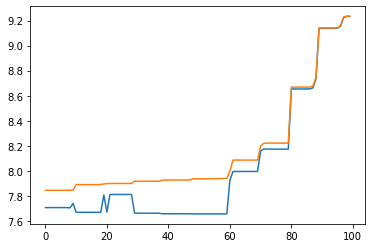

In [9]:
plt.plot(np.log(-results['mean_train_neg_mean_squared_error'].values))
plt.plot(np.log(-results['mean_test_neg_mean_squared_error'].values))

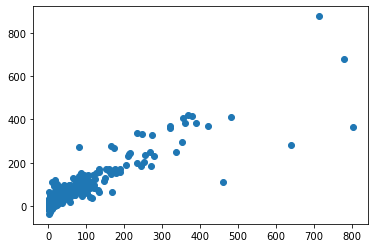

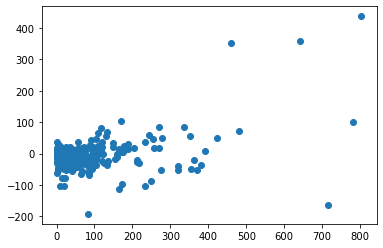

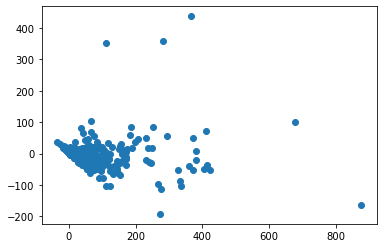

In [10]:
search.best_estimator_.fit(train[X], train[y])

y_true = validation[y]
y_pred = search.best_estimator_.predict(validation[X])
errors = y_true - y_pred

plt.scatter(y_true, y_pred)
plt.show()

plt.scatter(y_true, errors)
plt.show()

plt.scatter(y_pred, errors)
plt.show()

In [11]:
np.mean(np.square(errors))

1669.6628093580096